## 细胞核DAPI图像数据预处理
数据来源：https://www.10xgenomics.com/datasets/xenium-protein-ffpe-human-renal-carcinoma

In [1]:
import h5py
import numpy as np
from scipy import sparse
import pandas as pd
from scipy.sparse import csc_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import tifffile
import os
from PIL import Image
from tqdm import tqdm
from skimage.draw import polygon as polyfill 
from skimage.draw import polygon2mask

In [2]:
h5_path = "./data/cell_feature_matrix.h5"

In [3]:
with h5py.File(h5_path, "r") as f:
    def print_structure(name, obj):
        print(name)
    f.visititems(print_structure)

matrix
matrix/barcodes
matrix/data
matrix/features
matrix/features/_all_tag_keys
matrix/features/feature_type
matrix/features/genome
matrix/features/id
matrix/features/name
matrix/indices
matrix/indptr
matrix/shape


In [4]:
with h5py.File(h5_path, "r") as f:
    ## load sparse matrix
    data = f["matrix/data"][:]
    indices = f["matrix/indices"][:]
    indptr = f["matrix/indptr"][:]
    shape = tuple(f["matrix/shape"][:])  # (n_features x n_cells)

    ## load feature info
    feature_names = [x.decode() for x in f["matrix/features/name"][:]]
    feature_ids = [x.decode() for x in f["matrix/features/id"][:]]
    feature_types = [x.decode() for x in f["matrix/features/feature_type"][:]]
    barcodes = [x.decode() for x in f["matrix/barcodes"][:]]

print(shape)

(np.int32(543), np.int32(465545))


In [5]:
## load expression matrix
expr_matrix = csc_matrix((data, indices, indptr), shape=shape)
print("Shape of matrix (features x cells):", expr_matrix.shape)

Shape of matrix (features x cells): (543, 465545)


In [6]:
protein_idx = [i for i, ft in enumerate(feature_types) if ft == "Protein Expression"]
protein_names = [feature_names[i] for i in protein_idx]

ki67_idx_in_protein = protein_names.index("Ki-67")
ki67_feature_index = protein_idx[ki67_idx_in_protein]

print("Ki-67 feature row index:", ki67_feature_index)  

Ki-67 feature row index: 534


In [7]:
## extract Ki-67 expression matrix
ki67_expr = expr_matrix[ki67_feature_index, :].toarray().ravel()

print("Ki-67 表达 shape:", ki67_expr.shape)      
print("非零表达细胞数:", (ki67_expr > 0).sum())  

Ki-67 表达 shape: (465545,)
非零表达细胞数: 33459


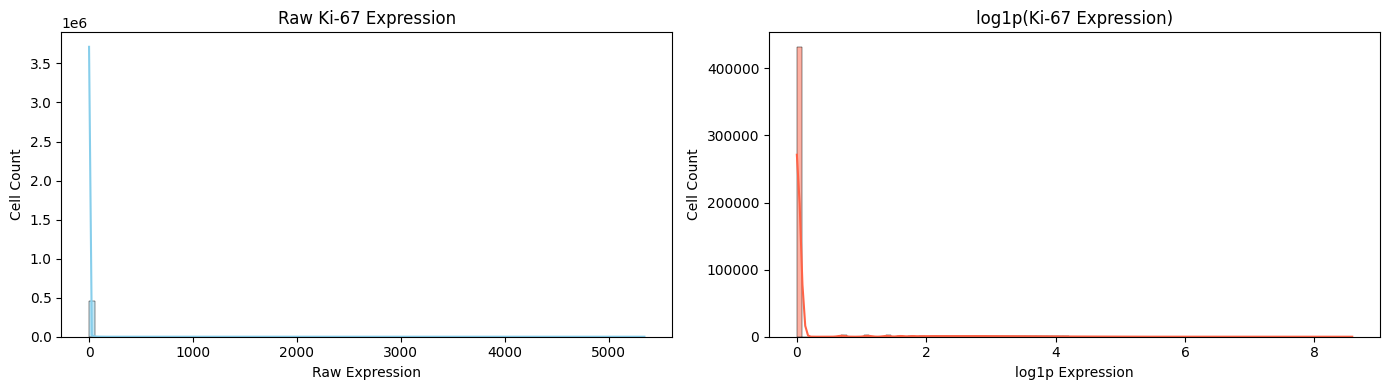

In [8]:
## 可视化Ki-67的表达分布
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.histplot(ki67_expr, bins=100, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title("Raw Ki-67 Expression")
axes[0].set_xlabel("Raw Expression")
axes[0].set_ylabel("Cell Count")

sns.histplot(np.log1p(ki67_expr), bins=100, kde=True, ax=axes[1], color='tomato')
axes[1].set_title("log1p(Ki-67 Expression)")
axes[1].set_xlabel("log1p Expression")
axes[1].set_ylabel("Cell Count")

plt.tight_layout()
plt.show()

In [9]:
print(len(ki67_expr[ki67_expr > 50]))

3848


In [11]:
## 设定Ki-67表达量的top98%为dividing类，反之为non-dividing类
#计算 Ki-67 表达的 98 分位数作为阈值
threshold = np.percentile(ki67_expr, 98)

# 打印这个阈值
print(f"Ki-67表达量的Top 98%阈值为: {threshold:.4f}")

# 按照这个阈值进行分类（Top 98% 为 dividing，其他为 non-dividing）
labels = (ki67_expr > threshold).astype(int)

cell_labels = pd.DataFrame({
    "barcode": barcodes,
    "Ki67_expr": ki67_expr,
    "dividing_label": labels
})

print(cell_labels["dividing_label"].value_counts())

## save
cell_labels.to_csv("./result/cell_labels_with_ki67.csv", index=False)

Ki-67表达量的Top 98%阈值为: 25.0000
dividing_label
0    456614
1      8931
Name: count, dtype: int64


In [12]:
## 查看其它增殖蛋白marker在不同组中的表达情况，看看label是否合理
cd45ra_idx_in_protein = protein_names.index("CD45RA")
cd45ra_feature_index = protein_idx[cd45ra_idx_in_protein]
cd45ra_expr = expr_matrix[cd45ra_feature_index, :].toarray().ravel()

pcna_idx_in_protein = protein_names.index("PCNA")
pcna_feature_index = protein_idx[pcna_idx_in_protein]
pcna_expr = expr_matrix[pcna_feature_index, :].toarray().ravel()

cd45ro_idx_in_protein = protein_names.index("CD45RO")
cd45ro_feature_index = protein_idx[cd45ro_idx_in_protein]
cd45ro_expr = expr_matrix[cd45ro_feature_index, :].toarray().ravel()

print("cd45ra 表达 shape:", cd45ra_expr.shape)      
print("非零表达细胞数:", (cd45ra_expr > 0).sum())  

print("pcna 表达 shape:", pcna_expr.shape)      
print("非零表达细胞数:", (pcna_expr > 0).sum())  

print("cd45ro 表达 shape:", cd45ro_expr.shape)      
print("非零表达细胞数:", (cd45ro_expr > 0).sum())  

cd45ra 表达 shape: (465545,)
非零表达细胞数: 103243
pcna 表达 shape: (465545,)
非零表达细胞数: 356664
cd45ro 表达 shape: (465545,)
非零表达细胞数: 171000


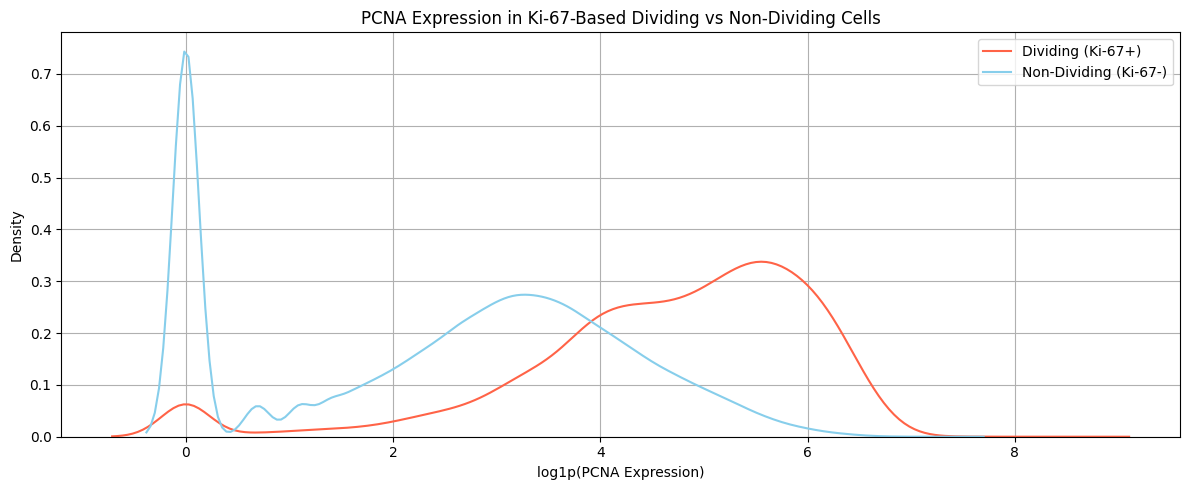

PCNA中位表达（Dividing组）：133.00
PCNA中位表达（Non-dividing组）：16.00


In [13]:
pcna_dividing = pcna_expr[labels == 1]
pcna_nondividing = pcna_expr[labels == 0]

# 2. 可视化表达分布
plt.figure(figsize=(12, 5))
sns.kdeplot(np.log1p(pcna_dividing), label='Dividing (Ki-67+)', color='tomato')
sns.kdeplot(np.log1p(pcna_nondividing), label='Non-Dividing (Ki-67-)', color='skyblue')
plt.xlabel("log1p(PCNA Expression)")
plt.ylabel("Density")
plt.title("PCNA Expression in Ki-67-Based Dividing vs Non-Dividing Cells")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. 中位数比较（数值验证）
print(f"PCNA中位表达（Dividing组）：{np.median(pcna_dividing):.2f}")
print(f"PCNA中位表达（Non-dividing组）：{np.median(pcna_nondividing):.2f}")

In [14]:
## 提取ki-67蛋白对应的基因MKI67的数据，辅助验证label的合理性
gene_name = "MKI67"

if gene_name in feature_names:
    gene_idx = feature_names.index(gene_name)
    print(f"Found gene {gene_name} at index {gene_idx}")
else:
    raise ValueError(f"Gene {gene_name} not found in features.")

mki67_expr = expr_matrix[gene_idx, :].toarray().flatten()  # shape: (n_cells,)
print(f"MKI67 expression shape: {mki67_expr.shape}")


Found gene MKI67 at index 262
MKI67 expression shape: (465545,)


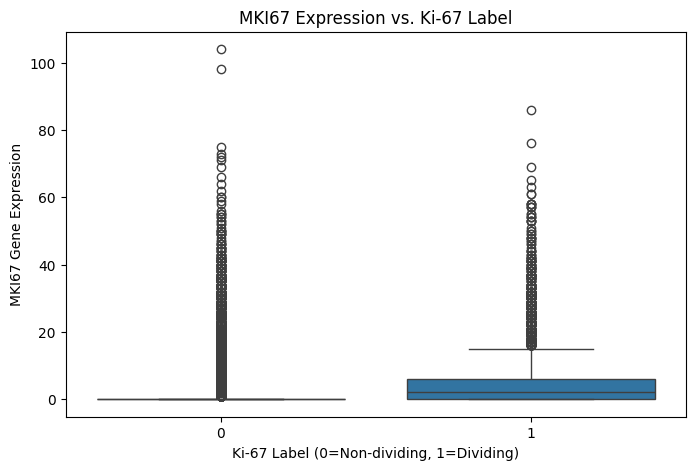

In [15]:
## 可视化MKI67在两个label下的表达分布
df_check = pd.DataFrame({
    "label": labels,
    "MKI67_expr": mki67_expr
})

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_check, x="label", y="MKI67_expr")
plt.title("MKI67 Expression vs. Ki-67 Label")
plt.xlabel("Ki-67 Label (0=Non-dividing, 1=Dividing)")
plt.ylabel("MKI67 Gene Expression")
plt.show()

In [16]:
## 读取细胞位置文件(这里应该用细胞核的位置中心来定义patch，应该运行下面的代码块)
table = pq.read_table("./data/cells.parquet")
cells_df = table.to_pandas()
print(cells_df.head())

      cell_id  x_centroid   y_centroid  transcript_counts  \
0  aaaacegh-1   36.700603  3494.752686                 67   
1  aaaaeiai-1   54.136509  3575.493896                 67   
2  aaaagkmn-1   49.582512  3534.720215                213   
3  aaaagncl-1   44.689571  3494.389160                 93   
4  aaaahjoa-1   19.052032  3595.543213                 39   

   control_probe_counts  genomic_control_counts  control_codeword_counts  \
0                     0                       0                        0   
1                     0                       0                        0   
2                     0                       0                        0   
3                     0                       0                        0   
4                     0                       0                        0   

   unassigned_codeword_counts  deprecated_codeword_counts  total_counts  \
0                           0                           0            67   
1                         

In [16]:
# print(table.schema)

In [ ]:
## 读取细胞核位置文件
nucleus_table = pq.read_table("./data/nucleus_boundaries.parquet")
nuclues_df = nucleus_table.to_pandas()
print(nuclues_df.head())

      cell_id   vertex_x     vertex_y  label_id
0  aaaaeiai-1  55.037502  3571.275146         1
1  aaaaeiai-1  54.187500  3571.912598         1
2  aaaaeiai-1  53.550003  3572.337646         1
3  aaaaeiai-1  53.337502  3572.337646         1
4  aaaaeiai-1  51.637501  3574.037598         1


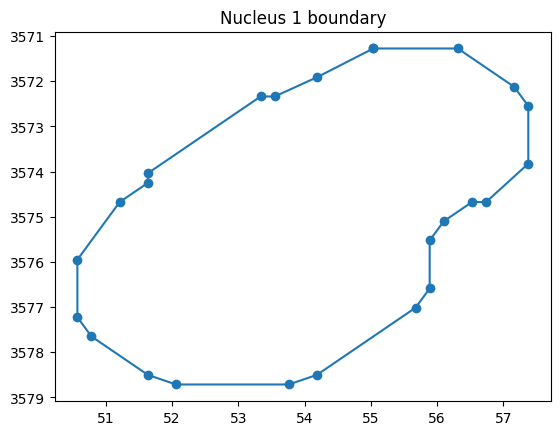

In [18]:
## 先简单可视化细胞核1的轮廓
label = 1
df_sub = nuclues_df[nuclues_df["label_id"] == label]

plt.plot(df_sub["vertex_x"], df_sub["vertex_y"], marker='o')
plt.gca().invert_yaxis()  # 图像y轴朝下
plt.title(f"Nucleus {label} boundary")
plt.show()

In [19]:
# 计算每个 label_id（即每个细胞核）的几何中心
nucleus_centroids = (
    nuclues_df.groupby(["label_id", "cell_id"])[["vertex_x", "vertex_y"]]
    .mean()
    .reset_index()
    .rename(columns={"vertex_x": "x_centroid", "vertex_y": "y_centroid"})
)

print(nucleus_centroids.head())

   label_id     cell_id  x_centroid   y_centroid
0         1  aaaaeiai-1   54.170502  3574.828125
1         2  aaaagkmn-1   49.818501  3533.917480
2         3  aaaagncl-1   44.744003  3494.171631
3         4  aaaahjoa-1   19.150501  3594.811523
4         5  aaaajioi-1   34.017002  3631.744141


In [20]:
## 发现有些细胞对应多个细胞核，查看具体信息
dups = nucleus_centroids["cell_id"].value_counts()
print("重复次数 >1 的 barcode 数量：", (dups > 1).sum())
print("示例重复 barcode：", dups[dups > 1].head())

重复次数 >1 的 barcode 数量： 11211
示例重复 barcode： cell_id
dpjbdnkk-1    10
epgmpggg-1     8
bpijfphi-1     7
eegilohl-1     7
cmmkgfmk-1     5
Name: count, dtype: int64


In [21]:
## 根据barcode来合并细胞周期标签和细胞核位置
# 统一barcode name
nucleus_centroids_renamed = nucleus_centroids.rename(columns={"cell_id": "barcode"})

# 合并 Ki-67 label
merged_df = pd.merge(nucleus_centroids_renamed, cell_labels, on="barcode", how="inner")

print("合并后行数：", len(merged_df))
print(merged_df[["barcode", "x_centroid", "y_centroid", "dividing_label", "Ki67_expr"]].head())

合并后行数： 471217
      barcode  x_centroid   y_centroid  dividing_label  Ki67_expr
0  aaaaeiai-1   54.170502  3574.828125               0          0
1  aaaagkmn-1   49.818501  3533.917480               1         40
2  aaaagncl-1   44.744003  3494.171631               0          0
3  aaaahjoa-1   19.150501  3594.811523               0          0
4  aaaajioi-1   34.017002  3631.744141               0          0


In [22]:
## 发现有重复的barcodes，代表一个细胞可能检测到多个细胞核，需要去除
# 找出重复的 barcodes（出现次数 > 1）
dup_barcodes = dups[dups > 1].index

# 在 merged_df 中筛选这些重复的 barcode
dup_df = merged_df[merged_df["barcode"].isin(dup_barcodes)]

# 统计 dividing_label == 1 的数量
num_dividing = (dup_df["dividing_label"] == 1).sum()
total_dup_cells = len(dup_df)

print(f"重复 barcode 对应的细胞数量：{total_dup_cells}")
print(f"其中 dividing_label == 1 的细胞数量：{num_dividing}")
print(f"占比：{num_dividing / total_dup_cells:.2%}")

重复 barcode 对应的细胞数量：23160
其中 dividing_label == 1 的细胞数量：523
占比：2.26%


In [23]:
# 从 merged_df 中剔除这些重复的 barcode
merged_df_unique = merged_df[~merged_df["barcode"].isin(dup_barcodes)].copy()

# 输出结果核查
print(f"去重后剩余细胞数：{len(merged_df_unique)}")
print(f"其中 dividing_label == 1 的数量：{(merged_df_unique['dividing_label'] == 1).sum()}")

去重后剩余细胞数：448057
其中 dividing_label == 1 的数量：8634


In [24]:
# 统计去重后的 cell_id 数量
unique_nucleus_cell_count = nuclues_df["cell_id"].nunique()
print(f"nuclues_df 中 unique cell_id 数量：{unique_nucleus_cell_count}")

nuclues_df 中 unique cell_id 数量：459268


In [25]:
missing_ids = set(cells_df["cell_id"]) - set(nucleus_centroids["cell_id"])
print("共缺失的 cell_id 数量：", len(missing_ids))

# 看看其中 dividing 的有多少
missing_dividing = cell_labels[cell_labels["barcode"].isin(missing_ids)]["dividing_label"].sum()
print("其中 dividing label = 1 的数量：", missing_dividing)

共缺失的 cell_id 数量： 6277
其中 dividing label = 1 的数量： 57


有 6,277 个细胞在 cells.parquet 中存在，但在 nucleus_boundaries.parquet 中没有细胞核信息。由于损失的细胞共有57个属于dividing的，影响不大。

In [26]:
# 只保留一个核细胞的细胞核轮廓记录
clean_nuc_df = nuclues_df[~nuclues_df["cell_id"].isin(dup_barcodes)].copy()

print(f"原始细胞数（cell_id 唯一值）：{nuclues_df['cell_id'].nunique():,}")
print(f"清洗后细胞数（唯一 cell_id，无重复）：{clean_nuc_df['cell_id'].nunique():,}")
print(f"剔除的多核细胞数量：{len(dup_barcodes):,}")


原始细胞数（cell_id 唯一值）：459,268
清洗后细胞数（唯一 cell_id，无重复）：448,057
剔除的多核细胞数量：11,211


In [27]:
## 导入图像
with tifffile.TiffFile('./data/ch0000_dapi.ome.tif') as tif:
    print(f"图像共有 {len(tif.pages)} 层") ## 一层
    dapi_img = tif.pages[0].asarray()  
    print("读取图像形状：", dapi_img.shape)

图像共有 1 层
读取图像形状： (27328, 54002)


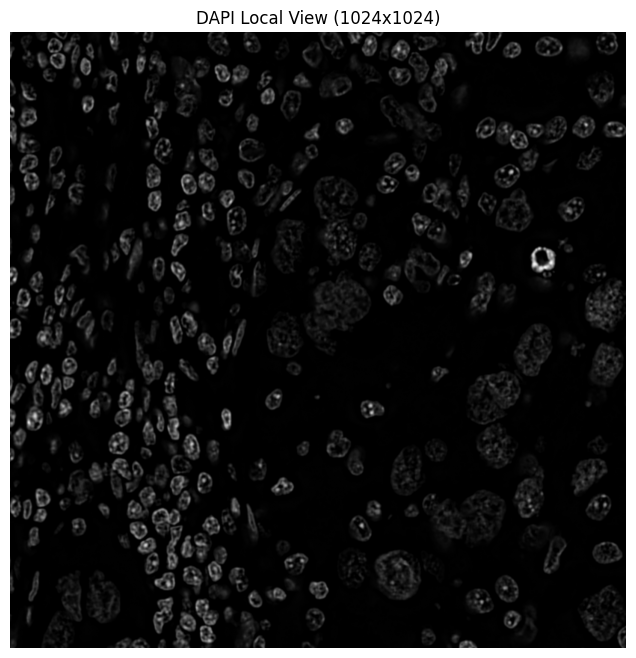

In [44]:
import matplotlib.pyplot as plt

# 中心区域裁剪
H, W = dapi_img.shape
center_y, center_x = H // 2, W // 2
crop_size = 1024  # 可改为 512, 2048 等

crop = dapi_img[
    center_y - crop_size // 2 : center_y + crop_size // 2,
    center_x - crop_size // 2 : center_x + crop_size // 2
]

plt.figure(figsize=(8, 8))
plt.imshow(crop, cmap='gray')
plt.title(f"DAPI Local View ({crop_size}x{crop_size})")
plt.axis('off')
plt.show()

In [ ]:
## 查看DAPI图的metadata
mipurl = './data/ch0000_dapi.ome.tif'

with tifffile.TiffFile(mipurl) as tif:
    for tag in tif.pages[0].tags.values():
        if tag.name == 'ImageDescription':
            print(tag.name+":", tag.value)

In [ ]:
## scale_factor设置为0.2125(参考：https://kb.10xgenomics.com/hc/en-us/articles/11636252598925-What-are-the-Xenium-image-scale-factors?utm_source=chatgpt.com)
## 裁剪patch+QC
def extract_dapi_patches(
    dapi_img, 
    merged_df,              # 包含 barcode, x_centroid(µm), y_centroid(µm), dividing_label
    nucleus_df,             # 包含 cell_id(barcode), vertex_x(µm), vertex_y(µm), label_id
    patch_um=20,            # patch大小（单位µm）
    scale=0.2125,           # µm -> px 的缩放系数
    normalize=True,         # 是否归一化图像
    qc_min_mean=0.01,       # 荧光强度下限
    qc_max_mean=0.99,        # 荧光强度上限
    max_samples = 20
):
    patch_size = int(round(patch_um / scale))
    if patch_size % 2 == 0:
        patch_size += 1
    half_size = patch_size // 2

    df = merged_df.copy()
    df["x_px"] = (df["x_centroid"] / scale).round().astype(int)
    df["y_px"] = (df["y_centroid"] / scale).round().astype(int)

    # ===============================
    # 构建 barcode → list of (xs, ys) 多边形列表（全局像素坐标）
    # ===============================
    poly_lookup = {}
    nuc = nucleus_df.copy()

    # 排序顶点顺序列（若存在）
    vorder_col = next((c for c in nuc.columns if "order" in c.lower()), None)

    group_cols = ["cell_id"]
    if "label_id" in nuc.columns:
        group_cols.append("label_id")

    for keys, g in nuc.groupby(group_cols):
        if vorder_col:
            g = g.sort_values(vorder_col)
        if len(g) < 3:
            continue
        xs = (g["vertex_x"].to_numpy(dtype=np.float64) / scale)
        ys = (g["vertex_y"].to_numpy(dtype=np.float64) / scale)
        cell_id = keys[0] if isinstance(keys, tuple) else keys
        poly_lookup.setdefault(cell_id, []).append((xs, ys))

    # ===============================
    # 主循环：裁剪、掩膜、归一化、质控
    # ===============================
    patches, labels, barcodes = [], [], []
    H, W = dapi_img.shape[:2]
    count = 0   

    for _, row in tqdm(df.iterrows(), total=len(df)):
        bc = row["barcode"]
        x, y = int(row["x_px"]), int(row["y_px"])
        label = int(row["dividing_label"])

        # 越界直接跳过
        if x - half_size < 0 or x + half_size >= W or y - half_size < 0 or y + half_size >= H:
            continue

        if bc not in poly_lookup:
            continue

        # 裁剪patch
        patch = dapi_img[y - half_size : y + half_size + 1, x - half_size : x + half_size + 1].astype(np.float32)

        # 创建mask（bool数组）
        mask = np.zeros((patch_size, patch_size), dtype=bool)
        for xs_glob, ys_glob in poly_lookup[bc]:
            xs_local = xs_glob - (x - half_size)
            ys_local = ys_glob - (y - half_size)
            rr, cc = polyfill(ys_local, xs_local, shape=mask.shape)
            mask[rr, cc] = True

        # 核外区域设置为 0
        patch[~mask] = 0.0

        # 若图像全为 0，则跳过
        if patch.max() == patch.min():
            continue

        # 归一化（仅限非零区域）
        if normalize:
            valid_pixels = patch[mask]
            pmin, pmax = valid_pixels.min(), valid_pixels.max()
            if pmax > pmin:
                patch[mask] = (valid_pixels - pmin) / (pmax - pmin + 1e-5)
            else:
                continue

        # 强度 QC
        mean_intensity = patch[mask > 0].mean()
        if not (qc_min_mean <= mean_intensity <= qc_max_mean):
            continue

        # 收集数据
        patches.append(patch)
        labels.append(label)
        barcodes.append(bc)
        count += 1

        if max_samples is not None and count >= max_samples:
            print(f"提前终止，仅提取前 {max_samples} 个样本用于测试")
            break

    # 样本不足报错
    if len(patches) == 0:
        raise RuntimeError("没有通过边界/掩膜/QC 的patch，请检查输入与阈值设置。")

    patches = np.stack(patches).astype(np.float32)  # shape: (N, H, W)
    labels = np.asarray(labels, dtype=np.int8)
    barcodes = np.asarray(barcodes, dtype=object)

    print(f"成功提取 {len(patches):,} 个 patch，尺寸：{patches.shape[1:]}")

    return patches, labels, barcodes

In [36]:
patches, labels, barcodes = extract_dapi_patches(
    dapi_img=dapi_img,
    merged_df=merged_df_unique,
    nucleus_df=clean_nuc_df,
    patch_um=20,
    scale=0.2125,
    normalize=True,
    qc_min_mean=0.01,
    qc_max_mean=0.99,
    max_samples=len(merged_df_unique) * 0.35
)

 35%|███▌      | 156967/448057 [04:04<07:32, 643.26it/s] 


⚠️ 提前终止，仅提取前 156819.94999999998 个样本用于测试
✅ 成功提取 156,820 个 patch，尺寸：(95, 95)


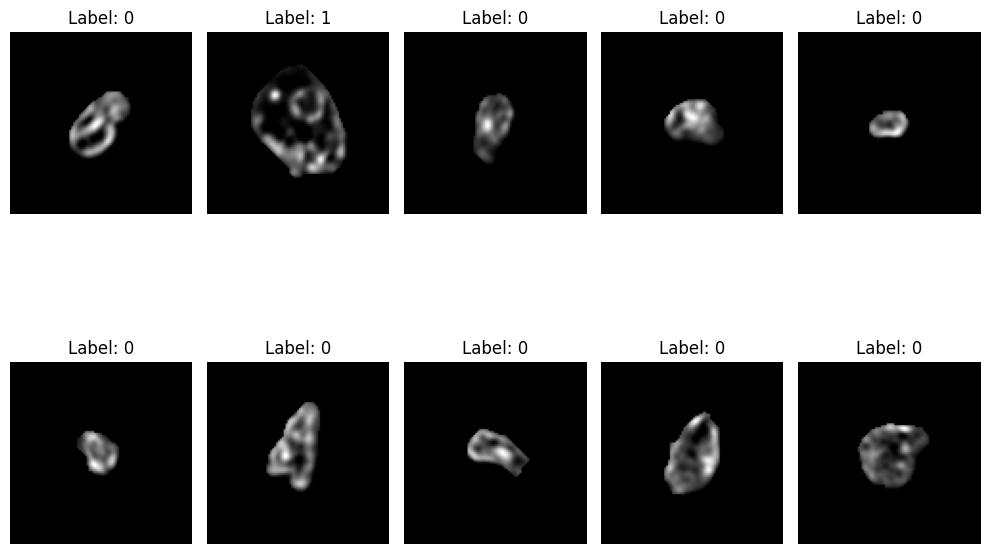

In [30]:
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(patches[i], cmap="gray")
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [40]:
## 保存图像为h5文件
def save_patches_to_hdf5(images, labels, barcodes, out_dir="./result"):
    num_samples = len(patches)
    out_path = f"{out_dir}/dapi_patches_20um_clean_{num_samples}.h5"

    with h5py.File(out_path, "w") as f:
        f.create_dataset("images", data=images, compression="gzip")
        f.create_dataset("labels", data=labels)
        f.create_dataset("barcodes", data=barcodes, dtype=h5py.string_dtype(encoding='utf-8'))
    
    print(f"已保存 {len(images)} 个 patch 到 HDF5 文件：{out_path}")
    print(f"HDF5 中图像 shape: {images.shape}, 标签 shape: {labels.shape}")

save_patches_to_hdf5(patches, labels, barcodes, out_dir="./result")

已保存 156820 个 patch 到 HDF5 文件：./result/dapi_patches_20um_clean_156820.h5
HDF5 中图像 shape: (156820, 95, 95), 标签 shape: (156820,)
